# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.


## Описание проекта

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.
Шаги для выбора локации обычно такие:
- В избранном регионе собирают характеристики для скважин: качество нефти и объём её запасов;
- Строят модель для предсказания объёма запасов в новых скважинах;
- Выбирают скважины с самыми высокими оценками значений;
- Определяют регион с максимальной суммарной прибылью отобранных скважин.

Вам предоставлены пробы нефти в трёх регионах. Характеристики для каждой скважины в регионе уже известны. Постройте модель для определения региона, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой Bootstrap.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

## Загрузка и подготовка данных

Данные геологоразведки трёх регионов находятся в файлах:
- /datasets/geo_data_0.csv
- /datasets/geo_data_1.csv
- /datasets/geo_data_2.csv
- id — уникальный идентификатор скважины;
- f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);
- product — объём запасов в скважине (тыс. баррелей).

У нас три датасета, вызывать одни и те же функции для анализа нет смысла - напишем функции

In [2]:
def drawCorrHeatMap(df):
    corr = df.corr()
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    mask = np.triu(np.ones_like(corr, dtype=bool))

    fig, ax = plt.subplots(figsize=(10, 6))
    sns.heatmap(corr, center=0, cmap="coolwarm", square=True,
                linewidth=0.3, cbar_kws={"shrink": .8}, annot=True, mask=mask)
    ax.set_title("Корреляции признаков")
    plt.show()

In [3]:
def checkDatasets(filename):
    df = pd.read_csv(filename)

    display(df.head())

    display(df.info())

    display(df.describe().T)

    drawCorrHeatMap(df)

    df.hist(bins=50, figsize=(15, 15))
    plt.show()

    print("Полные дубликаты")
    display(df.duplicated().sum())

    print("Дубликаты по id")
    display(df.duplicated(subset='id').sum())

    print("Список дубликатов")
    display(df[df.duplicated(subset='id', keep=False)].sort_values(by='id'))

    return df

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

,count,mean,std,min,25%,50%,75%,max
f0,100000.0,0.500419,0.871832,-1.408605,-0.072580,0.502360,1.073581,2.362331
f1,100000.0,0.250143,0.504433,-0.848218,-0.200881,0.250252,0.700646,1.343769
f2,100000.0,2.502647,3.248248,-12.088328,0.287748,2.515969,4.715088,16.003790
product,100000.0,92.500000,44.288691,0.000000,56.497507,91.849972,128.564089,185.364347


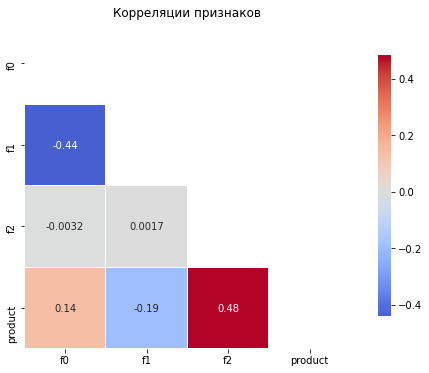

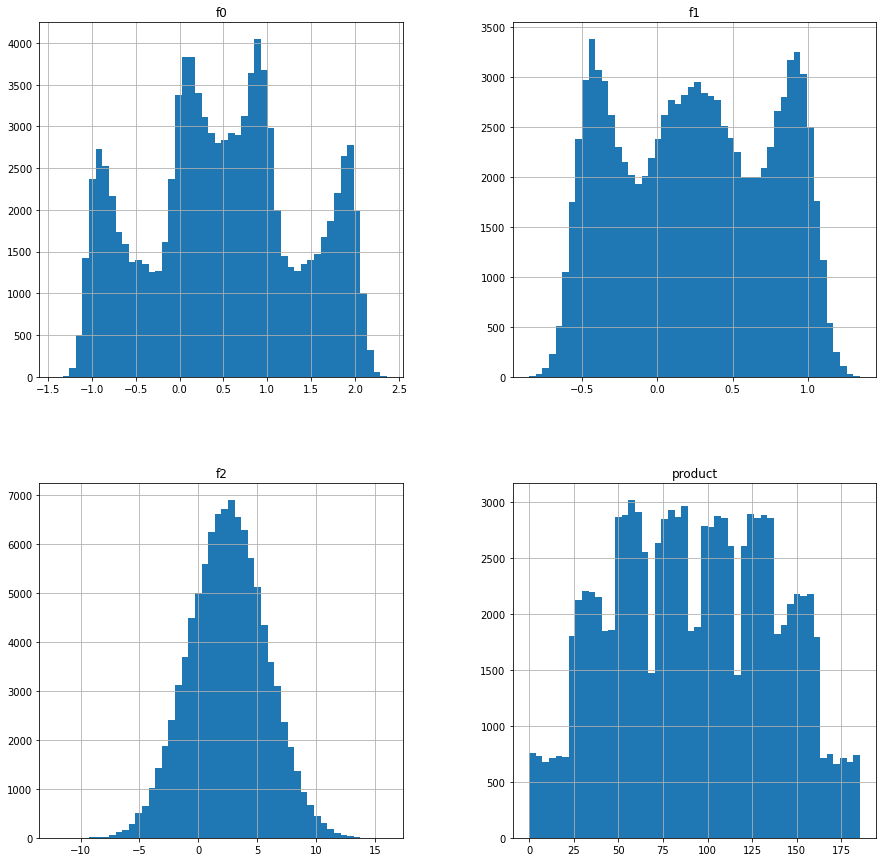

Полные дубликаты


0

Дубликаты по id


10

Список дубликатов


,id,f0,f1,f2,product
66136,74z30,1.084962,-0.312358,6.990771,127.643327
64022,74z30,0.741456,0.459229,5.153109,140.771492
51970,A5aEY,-0.180335,0.935548,-2.094773,33.020205
3389,A5aEY,-0.039949,0.156872,0.209861,89.249364
69163,AGS9W,-0.933795,0.116194,-3.655896,19.230453
42529,AGS9W,1.454747,-0.479651,0.683380,126.370504
931,HZww2,0.755284,0.368511,1.863211,30.681774
7530,HZww2,1.061194,-0.373969,10.430210,158.828695
63593,QcMuo,0.635635,-0.473422,0.862670,64.578675
1949,QcMuo,0.506563,-0.323775,-2.215583,75.496502


In [4]:
df0 = checkDatasets('/datasets/geo_data_0.csv')

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

,count,mean,std,min,25%,50%,75%,max
f0,100000.0,1.141296,8.965932,-31.609576,-6.298551,1.153055,8.621015,29.421755
f1,100000.0,-4.796579,5.119872,-26.358598,-8.267985,-4.813172,-1.332816,18.734063
f2,100000.0,2.494541,1.703572,-0.018144,1.000021,2.011479,3.999904,5.019721
product,100000.0,68.825000,45.944423,0.000000,26.953261,57.085625,107.813044,137.945408


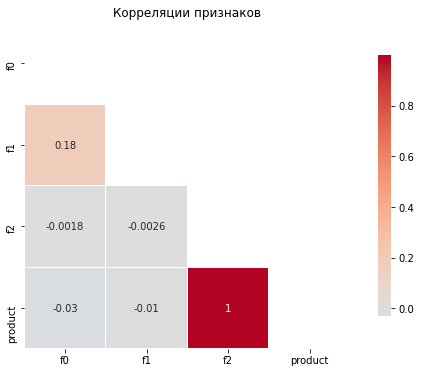

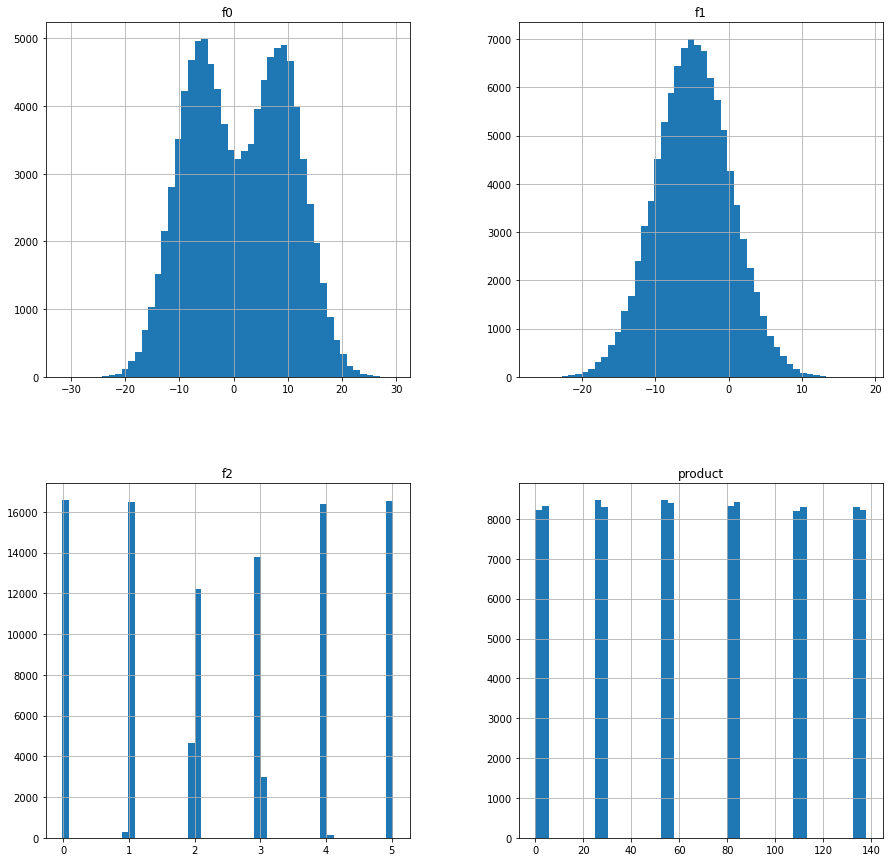

Полные дубликаты


0

Дубликаты по id


4

Список дубликатов


,id,f0,f1,f2,product
5849,5ltQ6,-3.435401,-12.296043,1.999796,57.085625
84461,5ltQ6,18.213839,2.191999,3.993869,107.813044
1305,LHZR0,11.170835,-1.945066,3.002872,80.859783
41906,LHZR0,-8.989672,-4.286607,2.009139,57.085625
2721,bfPNe,-9.494442,-5.463692,4.006042,110.992147
82178,bfPNe,-6.202799,-4.820045,2.995107,84.038886
47591,wt4Uk,-9.091098,-8.109279,-0.002314,3.179103
82873,wt4Uk,10.259972,-9.376355,4.994297,134.766305


In [5]:
df1 = checkDatasets('/datasets/geo_data_1.csv')

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

,count,mean,std,min,25%,50%,75%,max
f0,100000.0,0.002023,1.732045,-8.760004,-1.162288,0.009424,1.158535,7.238262
f1,100000.0,-0.002081,1.730417,-7.084020,-1.174820,-0.009482,1.163678,7.844801
f2,100000.0,2.495128,3.473445,-11.970335,0.130359,2.484236,4.858794,16.739402
product,100000.0,95.000000,44.749921,0.000000,59.450441,94.925613,130.595027,190.029838


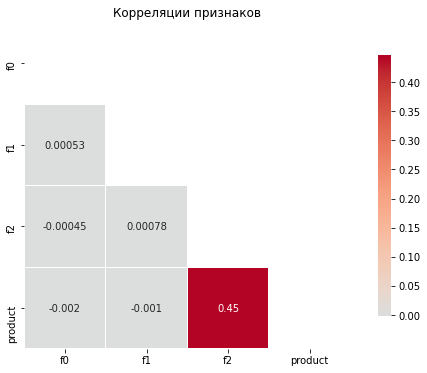

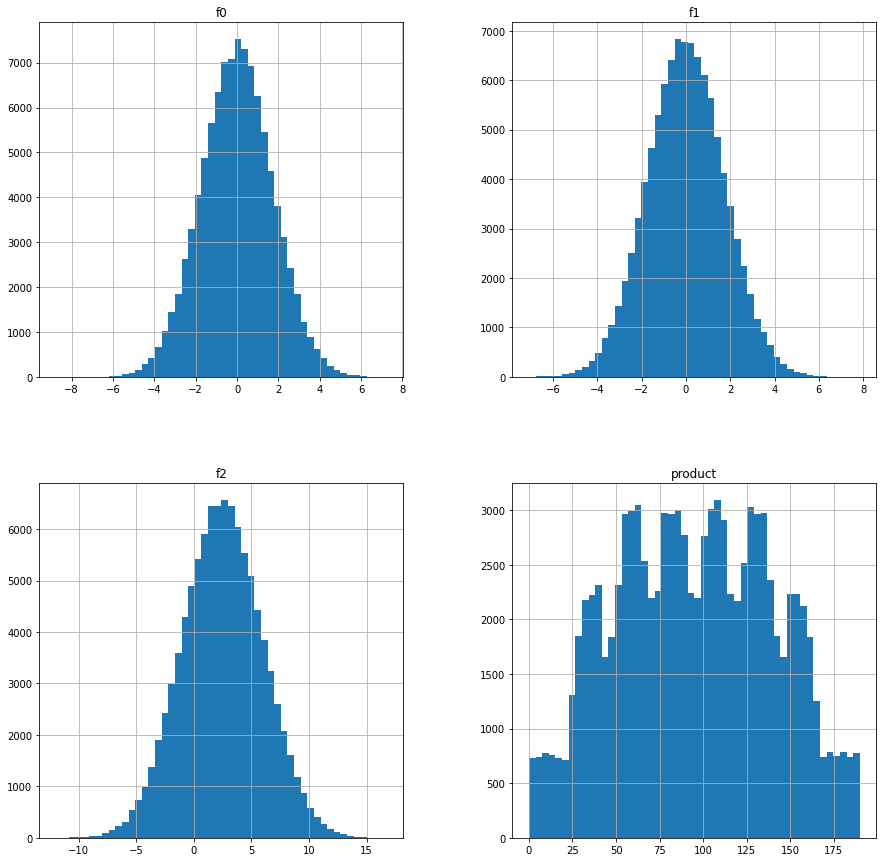

Полные дубликаты


0

Дубликаты по id


4

Список дубликатов


,id,f0,f1,f2,product
45404,KUPhW,0.231846,-1.698941,4.990775,11.716299
55967,KUPhW,1.211150,3.176408,5.543540,132.831802
11449,VF7Jo,2.122656,-0.858275,5.746001,181.716817
49564,VF7Jo,-0.883115,0.560537,0.723601,136.233420
44378,Vcm5J,-1.229484,-2.439204,1.222909,137.968290
95090,Vcm5J,2.587702,1.986875,2.482245,92.327572
28039,xCHr8,1.633027,0.368135,-2.378367,6.120525
43233,xCHr8,-0.847066,2.101796,5.597130,184.388641


In [6]:
df2 = checkDatasets('/datasets/geo_data_2.csv')

Вывод:

Данные полные, без пропусков. 

У всех датасетов наблюдается сильная кореляция с `f2`, у второго датасета вообще равна единице. Линайная регрессия будет счастлива)

У датасетов наблюдаются дубликаты по уникальным `id`. Это странно. Но этому есть интресное объяснение, предложенное пользоваьелем нашего Slack'a @Даниель Чертыковцев:
```
я пару раз читал отчет по геологоразведке и думаю что здесь может быть интересный вариант связанный с тем, что для одной скважины посчитана возможная выработка при разных вариантах ее освоения (глубина бурения, наклон, обеспечение подкачки давлением). соответственно с одной тсороны мы имеем одну и туже скважину. Но как бизнес объект добычи две разных при разных кап.вложениях на разработку. Не забываем также что зачастую организация ограничена в мощностях которые она может доставить в дикую степь.
```

Адекватным подходом будет запросить разъяснение у экспертов. У нас нет такой возможности, дубликатов сравнительно мало, поэтому оставим их.

## Обучение и проверка модели



- 2.1. Разбейте данные на обучающую и валидационную выборки в соотношении 75:25
- 2.2. Обучите модель и сделайте предсказания на валидационной выборке.
- 2.3. Сохраните предсказания и правильные ответы на валидационной выборке.
- 2.4  Напечатайте на экране средний запас предсказанного сырья и RMSE модели.
- 2.5. Проанализируйте результаты.

In [7]:
def train_model(data, debug_mode=False):
    features = data.drop(['product', 'id'], axis=1)
    target = data['product']

    features_train, features_valid, target_train, target_valid = train_test_split(
        features, target, test_size=0.2, shuffle=True, random_state=42)

    if debug_mode:
        print("begin check data split")
        print(features.shape[0], features_train.shape[0] + features_valid.shape[0])
        print(target.shape[0], features_train.shape[0] + target_valid.shape[0])
        print(features.shape[1], features_train.shape[1], features_valid.shape[1])
        print("end check data split\n")

    # Под вопросом -- я не знаю насколько это здесь нужно. 
    # И вообще - можно ли нормировать данные по каждому датасету отдельно
    # scaler = StandardScaler()
    # scaler.fit(features_train)
    # pd.options.mode.chained_assignment = None

    # features_train = scaler.transform(features_train)
    # features_train.head()

    # features_valid = scaler.transform(features_valid)
    # features_valid.head()

    model = LinearRegression()

    model.fit(features_train, target_train)

    target_prediction = model.predict(features_valid)

    rmse = mean_squared_error(target_valid, target_prediction, squared=False)

    if debug_mode:
        print(f"prediction {sum(target_prediction)}")
        print(f"real {sum(target_valid)}")
        print(f"rmse {rmse}")

    return target_prediction, target_valid, rmse

In [8]:
target_prediction_0, target_valid_0, rmse_0 = train_model(df0, debug_mode=True)

begin check data split
100000 100000
100000 100000
3 3 3
end check data split

prediction 1851155.877296259
real 1850172.477738236
rmse 37.65063757119425


In [9]:
target_prediction_1, target_valid_1, rmse_1 = train_model(df1, debug_mode=True)

begin check data split
100000 100000
100000 100000
3 3 3
end check data split

prediction 1366657.7201713724
real 1366849.9032197215
rmse 0.8908426254553105


In [10]:
target_prediction_2, target_valid_2, rmse_2 = train_model(df2, debug_mode=True)

begin check data split
100000 100000
100000 100000
3 3 3
end check data split

prediction 1897180.5157246809
real 1901369.0189468334
rmse 40.157688186301726


## Подготовка к расчёту прибыли

Условия задачи:
Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
- При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
- Бюджет на разработку скважин в регионе — 10 млрд рублей.
- При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
- После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.



3.1. Все ключевые значения для расчётов сохраните в отдельных переменных

3.2. Рассчитайте достаточный объём сырья для безубыточной разработки новой скважины. Сравните полученный объём сырья со средним запасом в каждом регионе

In [11]:
ALL_VIEWED_POINTS = 500
BEST_POINTS = 200
BUDGET = 10e9
INCOME_PER_BARREL = 450e3
LOWER_RISK_LIMIT = 0.025

In [12]:
# Бюджет для разработки одной скважины
budget_per_oil_well = BUDGET / BEST_POINTS

# необходимое количество нефти, которую надо добыть из одной скважины для окупаемости
minimum_volume = budget_per_oil_well / INCOME_PER_BARREL

print(f"Бюджет на одну скважину: {budget_per_oil_well}")
print(f"Порог окупаемости, 10e3 баррелей: {minimum_volume}")

Бюджет на одну скважину: 50000000.0
Порог окупаемости, 10e3 баррелей: 111.11111111111111


Напишите функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели:
- 4.1. Выберите скважины с максимальными значениями предсказаний.
- 4.2. Просуммируйте целевое значение объёма сырья, соответствующее этим предсказаниям.

In [13]:
def profit(target, predicted, count):
    target = pd.Series(target).reset_index(drop=True)
    predicted = pd.Series(predicted).reset_index(drop=True)

    predicted_sorted = predicted.sort_values(ascending=False)

    # в 10e3 баррелей
    selected = target.loc[predicted_sorted.index][:count]

    return (sum(selected) * INCOME_PER_BARREL) - BUDGET

## Расчёт прибыли и рисков 

- 5.1. Примените технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли.
- 5.2. Найдите среднюю прибыль, 95%-й доверительный интервал и риск убытков. Убыток — это отрицательная прибыль.
- 5.3. Напишите выводы: предложите регион для разработки скважин и обоснуйте выбор.

In [14]:
def bootstrap(target, predicted):
    random_state = np.random.RandomState(seed=42)

    target = pd.Series(target).reset_index(drop=True)
    predicted = pd.Series(predicted).reset_index(drop=True)

    values = []

    for i in range(1000):
        target_subsample = target.sample(ALL_VIEWED_POINTS, replace=True, random_state=random_state)
        probs_subsample = predicted.loc[target_subsample.index]
        values.append(profit(target_subsample, probs_subsample, BEST_POINTS))

    values = pd.Series(values)

    lower = 0.025
    upper = (1 - 0.025)
    mean = values.mean()

    q_lower = values.quantile(lower)
    q_upper = values.quantile(upper)

    print(f"Средняя выручка, млрд: {int(mean) / 10e9}")
    print(f"Доверительный интервал 0.95, млрд: [{int(q_lower) / 10e9} {int(q_upper) / 10e9}]")

    print(f"Риск убытков: {(values < 0).mean() * 100}%")

    values.hist(bins=30)


Средняя выручка, млрд: 0.0406287875
Доверительный интервал 0.95, млрд: [-0.010349654 0.0909757277]
Риск убытков: 6.3%


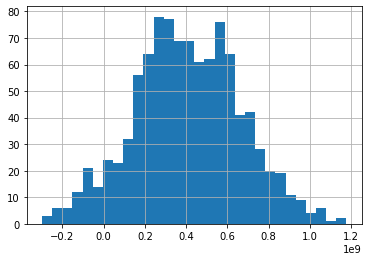

In [15]:
bootstrap(target_valid_0, target_prediction_0)

Средняя выручка, млрд: 0.0426051848
Доверительный интервал 0.95, млрд: [0.0004033009 0.0809477308]
Риск убытков: 2.1%


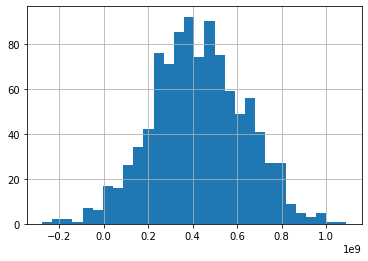

In [16]:
bootstrap(target_valid_1, target_prediction_1)

Средняя выручка, млрд: 0.0339536887
Доверительный интервал 0.95, млрд: [-0.0195792605 0.0837369179]
Риск убытков: 10.100000000000001%


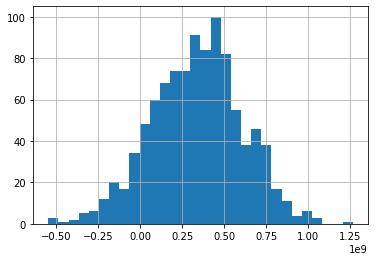

In [17]:
bootstrap(target_valid_2, target_prediction_2)

## Вывод:

В нулевом и первом регионе прибыль наибольшая. Но наименьший риск в первом регионе. 

Для разработки имеет смысл выбрать второй регион.

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные подготовлены
- [x]  Выполнен шаг 2: модели обучены и проверены
    - [x]  Данные корректно разбиты на обучающую и валидационную выборки
    - [x]  Модели обучены, предсказания сделаны
    - [x]  Предсказания и правильные ответы на валидационной выборке сохранены
    - [x]  На экране напечатаны результаты
    - [x]  Сделаны выводы
- [x]  Выполнен шаг 3: проведена подготовка к расчёту прибыли
    - [x]  Для всех ключевых значений созданы константы Python
    - [x]  Посчитано минимальное среднее количество продукта в месторождениях региона, достаточное для разработки
    - [x]  По предыдущему пункту сделаны выводы
    - [x]  Написана функция расчёта прибыли
- [x]  Выполнен шаг 4: посчитаны риски и прибыль
    - [x]  Проведена процедура *Bootstrap*
    - [x]  Все параметры бутстрепа соответствуют условию
    - [x]  Найдены все нужные величины
    - [x]  Предложен регион для разработки месторождения
    - [x]  Выбор региона обоснован